In [ ]:
import os, glob, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, json, seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D, BatchNormalization)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import load_img, img_to_array
tf.keras.backend.clear_session()

In [ ]:
BASE_DIR = r'food-101-splitpilihan'

train_path = os.path.join(BASE_DIR, 'train')
val_path   = os.path.join(BASE_DIR, 'val')
test_path  = os.path.join(BASE_DIR, 'test')

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS_STAGE1 = 20
EPOCHS_STAGE2 = 15
name_class = sorted(os.listdir(train_path))
NUM_CLASSES = len(name_class)

In [ ]:
def count_images(split_path):
    counts = {}
    for cls in sorted(os.listdir(split_path)):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len([
                f for f in os.listdir(cls_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return counts

train_counts = count_images(train_path)
val_counts   = count_images(val_path)
test_counts  = count_images(test_path)

print("=" * 70)
print(f"{'Class':<20} {'Train':<6} {'Val':<6} {'Test':<6} {'Total':<6}")
print("=" * 70)

for cls in train_counts:
    t = train_counts[cls]
    v = val_counts.get(cls, 0)
    te = test_counts.get(cls, 0)
    print(f"{cls:<20} {t:<6} {v:<6} {te:<6} {t+v+te:<6}")

print("=" * 70)
print("TOTAL")
print(f"Train: {sum(train_counts.values())}")
print(f"Val  : {sum(val_counts.values())}")
print(f"Test : {sum(test_counts.values())}")

Class                Train  Val    Test   Total 
cup_cakes            700    150    150    1000  
donuts               700    150    150    1000  
french_fries         700    150    150    1000  
fried_rice           700    150    150    1000  
hamburger            700    150    150    1000  
omelette             700    150    150    1000  
pizza                700    150    150    1000  
steak                700    150    150    1000  
sushi                700    150    150    1000  
takoyaki             700    150    150    1000  
TOTAL
Train: 7000
Val  : 1500
Test : 1500


In [ ]:
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    return img, label
def augment_tf(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.08)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, label

train_paths, train_labels = [], []
val_paths, val_labels = [], []
class_names = sorted(os.listdir(train_path))
class_indices = {cls: i for i, cls in enumerate(class_names)}
IMG_EXT = ('*.jpg', '*.jpeg', '*.png')

for cls in class_names:
    for ext in IMG_EXT:
        files = glob.glob(os.path.join(train_path, cls, ext))
        train_paths.extend(files)
        train_labels.extend([class_indices[cls]] * len(files))

for cls in class_names:
    for ext in IMG_EXT:
        files = glob.glob(os.path.join(val_path, cls, ext))
        val_paths.extend(files)
        val_labels.extend([class_indices[cls]] * len(files))
json.dump(class_names, open("class_names.json", "w"))

In [ ]:
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)
val_paths   = np.array(val_paths)
val_labels  = np.array(val_labels)
print("Train:", len(train_paths), len(train_labels))
print("Val  :", len(val_paths), len(val_labels))

assert len(train_paths) == len(train_labels)
assert len(val_paths) == len(val_labels)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.shuffle(len(train_paths))
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment_tf, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Train: 7000 7000
Val  : 1500 1500


In [ ]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation="softmax")])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True),
    ReduceLROnPlateau(
        monitor="val_loss",
        patience=3,
        factor=0.3,
        min_lr=1e-6)]

history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks)

Epoch 1/20
438/438 [==============================] - 40s 76ms/step - loss: 1.0177 - accuracy: 0.6794 - val_loss: 0.4687 - val_accuracy: 0.8460 - lr: 1.0000e-04
Epoch 2/20
438/438 [==============================] - 30s 69ms/step - loss: 0.5392 - accuracy: 0.8287 - val_loss: 0.3962 - val_accuracy: 0.8627 - lr: 1.0000e-04
Epoch 3/20
438/438 [==============================] - 30s 69ms/step - loss: 0.4284 - accuracy: 0.8664 - val_loss: 0.3593 - val_accuracy: 0.8820 - lr: 1.0000e-04
Epoch 4/20
438/438 [==============================] - 31s 70ms/step - loss: 0.3562 - accuracy: 0.8853 - val_loss: 0.3437 - val_accuracy: 0.8853 - lr: 1.0000e-04
Epoch 5/20
438/438 [==============================] - 31s 70ms/step - loss: 0.3117 - accuracy: 0.8999 - val_loss: 0.3293 - val_accuracy: 0.8920 - lr: 1.0000e-04
Epoch 6/20
438/438 [==============================] - 31s 70ms/step - loss: 0.2823 - accuracy: 0.9076 - val_loss: 0.3267 - val_accuracy: 0.8947 - lr: 1.0000e-04
Epoch 7/20
438/438 [==============

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks)

Epoch 1/15
438/438 [==============================] - 48s 91ms/step - loss: 0.7220 - accuracy: 0.7626 - val_loss: 0.5865 - val_accuracy: 0.8113 - lr: 1.0000e-05
Epoch 2/15
438/438 [==============================] - 38s 87ms/step - loss: 0.5289 - accuracy: 0.8283 - val_loss: 0.5088 - val_accuracy: 0.8353 - lr: 1.0000e-05
Epoch 3/15
438/438 [==============================] - 38s 87ms/step - loss: 0.4526 - accuracy: 0.8524 - val_loss: 0.4668 - val_accuracy: 0.8553 - lr: 1.0000e-05
Epoch 4/15
438/438 [==============================] - 38s 87ms/step - loss: 0.4120 - accuracy: 0.8627 - val_loss: 0.4386 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 5/15
438/438 [==============================] - 38s 87ms/step - loss: 0.3755 - accuracy: 0.8763 - val_loss: 0.4149 - val_accuracy: 0.8747 - lr: 1.0000e-05
Epoch 6/15
438/438 [==============================] - 38s 87ms/step - loss: 0.3318 - accuracy: 0.8904 - val_loss: 0.4011 - val_accuracy: 0.8793 - lr: 1.0000e-05
Epoch 7/15
438/438 [==============

In [ ]:
y_true = val_labels
y_pred_prob = model.predict(val_ds, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
report = classification_report(y_true,y_pred,target_names=class_names,digits=4)
print(report)

94/94 [==============================] - 6s 51ms/step
              precision    recall  f1-score   support

   cup_cakes     0.9184    0.9000    0.9091       150
      donuts     0.8608    0.9067    0.8831       150
french_fries     0.9412    0.9600    0.9505       150
  fried_rice     0.9262    0.9200    0.9231       150
   hamburger     0.9128    0.9067    0.9097       150
    omelette     0.8784    0.8667    0.8725       150
       pizza     0.9184    0.9000    0.9091       150
       steak     0.8800    0.8800    0.8800       150
       sushi     0.9007    0.8467    0.8729       150
    takoyaki     0.8734    0.9200    0.8961       150

    accuracy                         0.9007      1500
   macro avg     0.9010    0.9007    0.9006      1500
weighted avg     0.9010    0.9007    0.9006      1500



In [ ]:
test_paths, test_labels = [], []
for cls in class_names:
    for ext in IMG_EXT:
        files = glob.glob(os.path.join(test_path, cls, ext))
        test_paths.extend(files)
        test_labels.extend([class_indices[cls]] * len(files))

test_paths  = np.array(test_paths)
test_labels = np.array(test_labels)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(AUTOTUNE)

test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test Loss    : {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

94/94 [==============================] - 6s 60ms/step - loss: 0.3280 - accuracy: 0.9013
Test Loss    : 0.3280
Test Accuracy: 0.9013


In [ ]:
y_true = test_labels
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

94/94 [==============================] - 5s 53ms/step
              precision    recall  f1-score   support

   cup_cakes     0.9178    0.8933    0.9054       150
      donuts     0.8690    0.8400    0.8542       150
french_fries     0.9662    0.9533    0.9597       150
  fried_rice     0.8987    0.9467    0.9221       150
   hamburger     0.9178    0.8933    0.9054       150
    omelette     0.8667    0.8667    0.8667       150
       pizza     0.9437    0.8933    0.9178       150
       steak     0.8742    0.8800    0.8771       150
       sushi     0.8790    0.9200    0.8990       150
    takoyaki     0.8854    0.9267    0.9055       150

    accuracy                         0.9013      1500
   macro avg     0.9018    0.9013    0.9013      1500
weighted avg     0.9018    0.9013    0.9013      1500



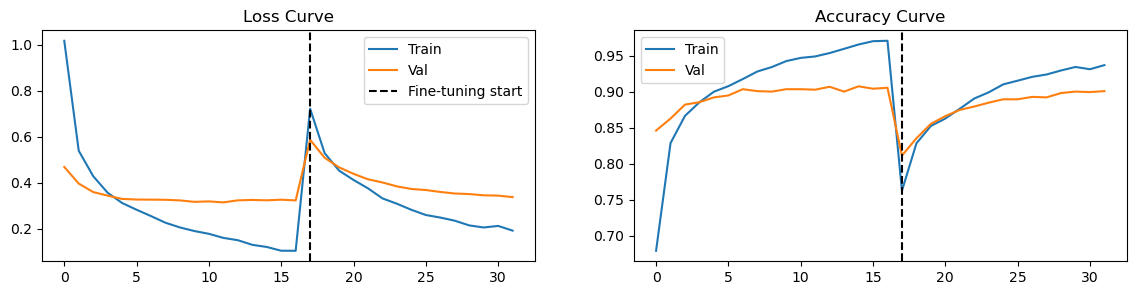

In [ ]:
def merge_history(h1, h2):
    history = {}
    for k in h1.history:
        history[k] = h1.history[k] + h2.history[k]
    return history

history = merge_history(history_stage1, history_stage2)
ft_start = len(history_stage1.history['loss'])
plt.figure(figsize=(14,3))

plt.subplot(1,2,1)
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.axvline(ft_start, color='k', linestyle='--', label='Fine-tuning start')
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.axvline(ft_start, color='k', linestyle='--')
plt.title("Accuracy Curve")
plt.legend()
plt.show()

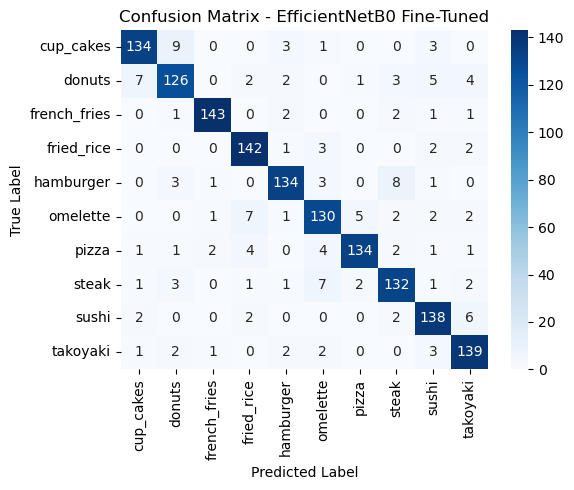

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=class_names,yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - EfficientNetB0 Fine-Tuned")
plt.tight_layout()
plt.show()

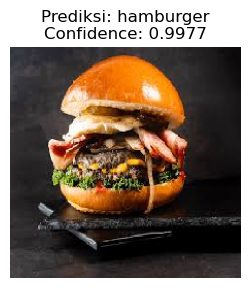

In [ ]:
def predict_image_with_display(model, image_path, class_names):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    preds = model.predict(img_array, verbose=0)[0]
    class_id = np.argmax(preds)
    confidence = preds[class_id]

    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Prediksi: {class_names[class_id]}\n"
        f"Confidence: {confidence:.4f}",
        fontsize=12)
    plt.show()
    return class_names[class_id], float(confidence)

label, conf = predict_image_with_display(model,r"gambar google\download (2).jpeg",class_names)